<a href="https://colab.research.google.com/github/FawneeCakes/sqlalchemy-challenge/blob/main/climate_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
# Find the latest version of spark 3.x  from https://downloads.apache.org/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.1'
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,393 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2,556 kB]
Hit:9 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,189 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net

In [3]:
# Import library
import sqlite3
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Connect to an SQLite database; use ':memory:' for an in-memory database
conn = sqlite3.connect(':memory:')

# **Reflect Tables into SQLAlchemy ORM**

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [7]:
# Import necessary libraries
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

# Define the database file path
db_path = "Resources/hawaii.sqlite"

# create engine to hawaii.sqlite
# just saying 'where is your datbase is located'
engine = create_engine(f"sqlite:///{db_path}")

In [8]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

<ipython-input-8-3aecdb707136>:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [9]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['station', 'measurement']

In [10]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create a session
session = Session(bind=engine)

# **Exploratory Precipitation Analysis**

In [13]:
# Find the most recent date in the data set.
most_recent = (session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0])
most_recent

'2017-08-23'

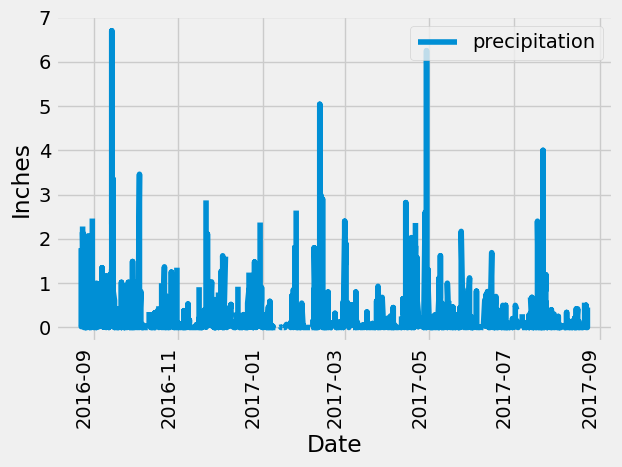

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
one_year = dt.date(2017, 8, 23) - pd.DateOffset(years=1)
one_year_date = dt.date(one_year.year, one_year.month, one_year.day)

# Calculate the date one year prior to the most recent date


# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation, columns=['date', 'precipitation'])
precipitation_df['date']= pd.to_datetime(precipitation_df['date'])

# Save the query results as a Pandas DataFrame. Explicitly set the column names

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by ='date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot('date', 'precipitation', rot=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(["precipitation"],loc='upper right')

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df['precipitation'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# **Exploratory Station Analysis**

In [17]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(Station.station)).all()

[(9,)]

In [18]:
# Design a query to find the most active stations
#(i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_rows = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()
station_rows

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
    .filter(Measurement.station=='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

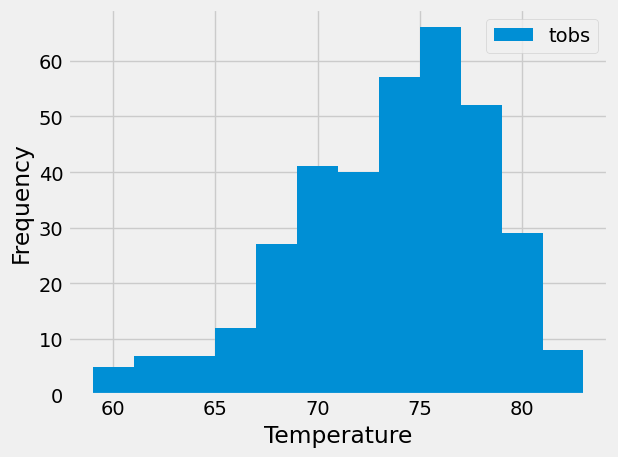

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
# and plot the results as a histogram

# Calculate the date one year from the last date in the dataset
from datetime import datetime, timedelta
last_date_str = session.query(func.max(Measurement.date)).scalar()
last_date = datetime.strptime(last_date_str, '%Y-%m-%d')
query_date = last_date - timedelta(days=365)

query_temperature = session.query(Measurement.tobs).\
filter(Measurement.station == "USC00519281").\
filter(Measurement.date >= query_date).all()
df2 = pd.DataFrame(query_temperature, columns = ["tobs"])
df2.plot.hist(bins = 12)
plt.xlabel('Temperature')
plt.tight_layout()

In [23]:
# Close Session
session.close()